In [97]:
import os
import astropy
import numpy as np
from astropy.table import Table
from astropy.table import Column
import glob
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

In [3]:
snidoutput = np.load("/mnt/c/Users/20xha/Documents/Caltech/Research/SNID_results_rlap3.npy", allow_pickle=True)

In [5]:
final_rcf_table = Table.from_pandas(pd.read_hdf("/mnt/c/users/20xha/Documents/Caltech/Research/final_rcf_table.h5"))

In [101]:
ZTable_best = Table(
                    names=("ZTF_Name", "z_snid", "z_snid_err"
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("U64", "float64", "float64"
                          )
                    )
for j in snidoutput:
    row = []
    row.append(j[0])
    good = j[1][np.where(j[1]["grade"] == "good")]
    if(len(good) != 0):
        row.append(float(np.mean(good[0]["z"])))
        row.append(float(np.sqrt(np.mean(good[0]["zerr"] ** 2))))
        ZTable_best.add_row(row)
ZTable_best_JoinedResults = astropy.table.join(ZTable_best, final_rcf_table)

In [6]:
ZTable_average_same = Table(
                    names=("ZTF_Name", "z_snid", "z_snid_err"
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("U64", "float64", "float64"
                          )
                    )
for j in snidoutput:
    row = []
    row.append(j[0])
    good = j[1][np.where(j[1]["grade"] == "good")]
    if(len(good) != 0):
        correct_type = j[1]["type"][0]
        correct = good[np.where(good["type"] == correct_type)[0]]
        if(len(correct) != 0):
            if(np.sum(correct[0:15]["zerr"] == 0) == 0):
                row.append(float(sum(correct[0:15]["z"] * (1/(correct[0:15]["zerr"] ** 2)))/sum(1/(correct[0:15]["zerr"] ** 2))))
                row.append(float(1 / (np.sqrt(np.sum(1 / correct[0:15]["zerr"] ** 2)))))
                ZTable_average_same.add_row(row)
ZTable_average_same_JoinedResults = astropy.table.join(ZTable_average_same, final_rcf_table)

In [44]:
ranges = np.linspace(0, 25, 26)
ResultsTable_List_rlap = []
count = 0

for i in ranges:
    ResultsTable = Table(
                    names=("ZTF_Name", "Closest"
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("U64", "U64"
                          )
                    )
    for j in snidoutput:
        row = []
        row.append(j[0])
        if(np.max(j[1]["rlap"]) > i):
            row.append(j[1][0]["type"])
            ResultsTable.add_row(row)
    
    count += 1
    if(len(ResultsTable) != 0):
        ResultsTable_List_rlap.append([i,ResultsTable])
    if(count% 100 == 0):
        print(count)
ResultsTable_List_rlap = np.asarray(ResultsTable_List_rlap)

In [45]:
negative = 0
positive = 0
for j in final_rcf_table:
    correct_1a = "Ia" in j["sn_type"]
    if(correct_1a):
        positive += 1
    if(not(correct_1a)):
        negative += 1

In [46]:
counters_rlap_1a = []
for i in ResultsTable_List_rlap:
    truepositive = 0
    falsepositive = 0
    JoinedResults = astropy.table.join(i[1], ZTable_average_same_JoinedResults)
    for j in JoinedResults:
        correct_1a = "Ia" in j["sn_type"]
        classified_1a = "Ia" in j["Closest"]
        if(correct_1a == True and classified_1a == True):
            truepositive += 1
        if(correct_1a != True and classified_1a == True):
            falsepositive += 1
    counters_rlap_1a.append([i[0],truepositive/(positive),falsepositive/(negative),len(JoinedResults), truepositive, falsepositive])
counters_rlap_1a = np.asarray(counters_rlap_1a)

Text(0, 0.5, 'True Positive Rate')

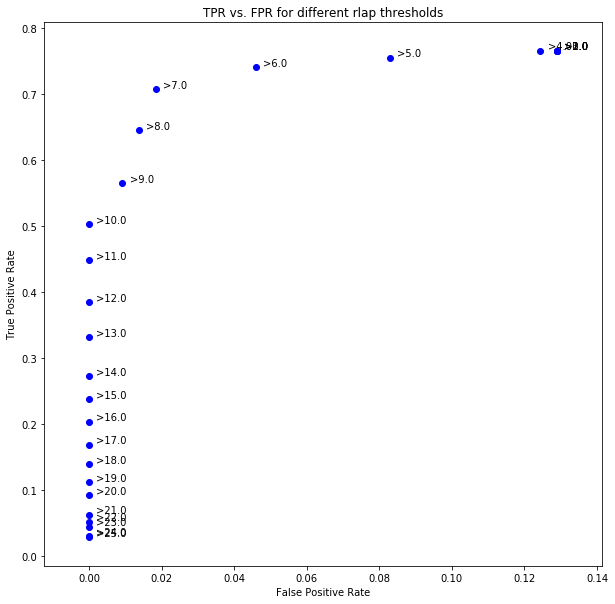

In [47]:
fig = plt.figure(figsize = (10,10))
plt.scatter(counters_rlap_1a[:,2], counters_rlap_1a[:,1], color = "blue")
for i in counters_rlap_1a:
    plt.text(i[2]+.002,i[1]+.002,">"+str(i[0]))
plt.title("TPR vs. FPR for different rlap thresholds")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [48]:
rlap10_redshift = astropy.table.join(ResultsTable_List_rlap[10][1], ZTable_average_same_JoinedResults)

In [57]:
indicies = []
counter = 0
for i in rlap10_redshift:
    if("Ia" in i["sn_type"]):
        indicies.append(counter)
    counter+=1

In [58]:
rlap10_redshift_Ia = rlap10_redshift[indicies]

In [65]:
regr_average_same_Ia_JoinedResults = linear_model.LinearRegression(fit_intercept = False)
rlap10_redshift_Ia_good = rlap10_redshift_Ia[np.where(rlap10_redshift_Ia["z_host"] > -.1)[0]]
regr_average_same_Ia_JoinedResults.fit(rlap10_redshift_Ia_good["z_host"].reshape(-1, 1), rlap10_redshift_Ia_good["z_snid"].reshape(-1, 1))

/home/hallflower/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [72]:
ranges_average_same_good_Ia = np.linspace(0, .2, 100)
ypredict_average_same_good_Ia = regr_average_same_Ia_JoinedResults.predict(ranges_average_same_good_Ia.reshape(-1, 1))

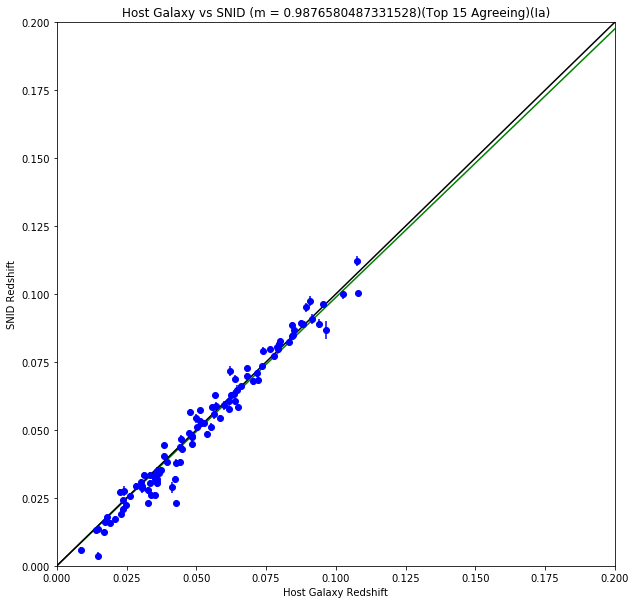

In [77]:
fig = plt.figure(figsize = (10,10))
plt.xlim(0,.2)
plt.ylim(0,.2)
plt.errorbar(rlap10_redshift_Ia_good["z_host"], rlap10_redshift_Ia_good["z_snid"], rlap10_redshift_Ia_good["z_snid_err"], fmt = "o", color = "blue")
plt.title("Host Galaxy vs SNID (m = " + str(regr_average_same_Ia_JoinedResults.coef_[0][0]) + ")(Top 15 Agreeing)(Ia)")
plt.xlabel("Host Galaxy Redshift")
plt.ylabel("SNID Redshift")
plt.plot(ranges_average_same_good_Ia, ypredict_average_same_good_Ia, color = "green")
plt.plot(ranges_average_same_good_Ia, ranges_average_same_good_Ia, color = "black")

In [100]:
print(stats.median_absolute_deviation(rlap10_redshift_Ia_good["z_snid"] - rlap10_redshift_Ia_good["z_host"]))
print(stats.median_absolute_deviation((rlap10_redshift_Ia_good["z_snid"] - rlap10_redshift_Ia_good["z_host"]) / rlap10_redshift_Ia_good["z_host"]))
print(stats.median_absolute_deviation(((rlap10_redshift_Ia_good["z_snid"] - rlap10_redshift_Ia_good["z_host"]) / rlap10_redshift_Ia_good["z_snid_err"])))
print(np.std(rlap10_redshift_Ia_good["z_snid"] - rlap10_redshift_Ia_good["z_host"]))
print(np.std((rlap10_redshift_Ia_good["z_snid"] - rlap10_redshift_Ia_good["z_host"]) / rlap10_redshift_Ia_good["z_host"]))
print(np.std(((rlap10_redshift_Ia_good["z_snid"] - rlap10_redshift_Ia_good["z_host"]) / rlap10_redshift_Ia_good["z_snid_err"])))

0.0038751047115081643
0.08233817688798246
3.147551523422346
0.005850586312436719
0.19190361756235094
4.923720051390305


In [92]:
regr_average_same_JoinedResults = linear_model.LinearRegression(fit_intercept = False)
rlap10_redshift_good = rlap10_redshift[np.where(rlap10_redshift["z_host"] > -.1)[0]]
regr_average_same_JoinedResults.fit(rlap10_redshift_good["z_host"].reshape(-1, 1), rlap10_redshift_good["z_snid"].reshape(-1, 1))

/home/hallflower/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [93]:
ranges_average_same_good = np.linspace(0, .2, 100)
ypredict_average_same_good = regr_average_same_JoinedResults.predict(ranges_average_same_good.reshape(-1, 1))

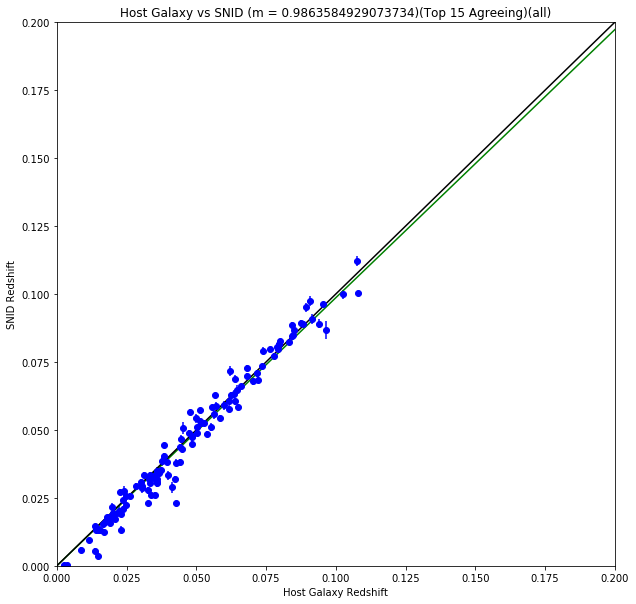

In [94]:
fig = plt.figure(figsize = (10,10))
plt.xlim(0,.2)
plt.ylim(0,.2)
plt.errorbar(rlap10_redshift_good["z_host"], rlap10_redshift_good["z_snid"], rlap10_redshift_good["z_snid_err"], fmt = "o", color = "blue")
plt.title("Host Galaxy vs SNID (m = " + str(regr_average_same_JoinedResults.coef_[0][0]) + ")(Top 15 Agreeing)(all)")
plt.xlabel("Host Galaxy Redshift")
plt.ylabel("SNID Redshift")
plt.plot(ranges_average_same_good, ypredict_average_same_good, color = "green")
plt.plot(ranges_average_same_good, ranges_average_same_good, color = "black")

Text(0.5, 1.0, 'SNID Residuals (deltaZ > 0.1)(Top 15 Agreeing)')

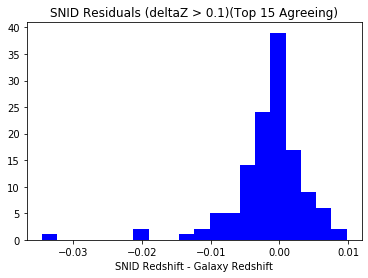

In [82]:
plt.hist(rlap10_redshift_good["z_snid"] - rlap10_redshift_good["z_host"], color = "blue", bins = 20)
plt.xlabel("SNID Redshift - Galaxy Redshift")
plt.title("SNID Residuals (deltaZ > 0.1)(Top 15 Agreeing)")

Text(0.5, 1.0, 'SNID Residuals (delta Z ratio > 0.5)(Top 15 Agreeing)')

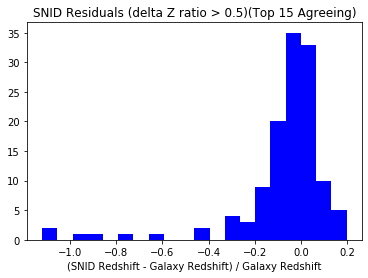

In [84]:
plt.hist(((rlap10_redshift_good["z_snid"] - rlap10_redshift_good["z_host"])/rlap10_redshift_good["z_host"]), color = "blue", bins = 20)
plt.xlabel("(SNID Redshift - Galaxy Redshift) / Galaxy Redshift")
plt.title("SNID Residuals (delta Z ratio > 0.5)(Top 15 Agreeing)")

In [87]:
np.sum(np.abs((rlap10_redshift_good["z_snid"] - rlap10_redshift_good["z_host"])/rlap10_redshift_good["z_host"]) > .5)

6

Text(0.5, 1.0, 'SNID Pull (delta z / sigma z > 10)(Top 15)')

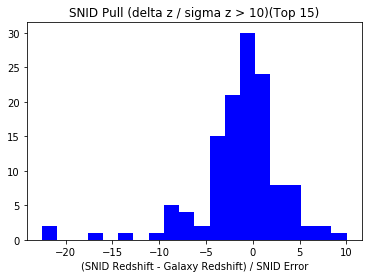

In [88]:
plt.hist(((rlap10_redshift_good["z_snid"] - rlap10_redshift_good["z_host"]) / rlap10_redshift_good["z_snid_err"]), color = "blue", bins = 20)
plt.xlabel("(SNID Redshift - Galaxy Redshift) / SNID Error")
plt.title("SNID Pull (delta z / sigma z > 10)(Top 15)")

In [98]:
print(stats.median_absolute_deviation(rlap10_redshift_good["z_snid"] - rlap10_redshift_good["z_host"]))
print(stats.median_absolute_deviation((rlap10_redshift_good["z_snid"] - rlap10_redshift_good["z_host"]) / rlap10_redshift_good["z_host"]))
print(stats.median_absolute_deviation(((rlap10_redshift_good["z_snid"] - rlap10_redshift_good["z_host"]) / rlap10_redshift_good["z_snid_err"])))

0.003505944599904567
0.08648895038153001
3.1111117976866227


In [96]:
print(np.std(rlap10_redshift_good["z_snid"] - rlap10_redshift_good["z_host"]))
print(np.std((rlap10_redshift_good["z_snid"] - rlap10_redshift_good["z_host"]) / rlap10_redshift_good["z_host"]))
print(np.std(((rlap10_redshift_good["z_snid"] - rlap10_redshift_good["z_host"]) / rlap10_redshift_good["z_snid_err"])))

0.005508510101857286
0.21611307581064576
4.63994112564349


In [104]:
rlap10_redshift_best = astropy.table.join(ResultsTable_List_rlap[10][1], ZTable_best_JoinedResults)

In [105]:
indicies = []
counter = 0
for i in rlap10_redshift_best:
    if("Ia" in i["sn_type"]):
        indicies.append(counter)
    counter+=1

In [106]:
rlap10_redshift_best_Ia = rlap10_redshift_best[indicies]

In [108]:
regr_best_Ia_JoinedResults = linear_model.LinearRegression(fit_intercept = False)
rlap10_redshift_best_Ia_good = rlap10_redshift_best_Ia[np.where(rlap10_redshift_best_Ia["z_host"] > -.1)[0]]
regr_best_Ia_JoinedResults.fit(rlap10_redshift_best_Ia_good["z_host"].reshape(-1, 1), rlap10_redshift_best_Ia_good["z_snid"].reshape(-1, 1))

/home/hallflower/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [109]:
ranges_average_same_good = np.linspace(0, .2, 100)
ypredict_average_same_good = regr_average_same_JoinedResults.predict(ranges_average_same_good.reshape(-1, 1))

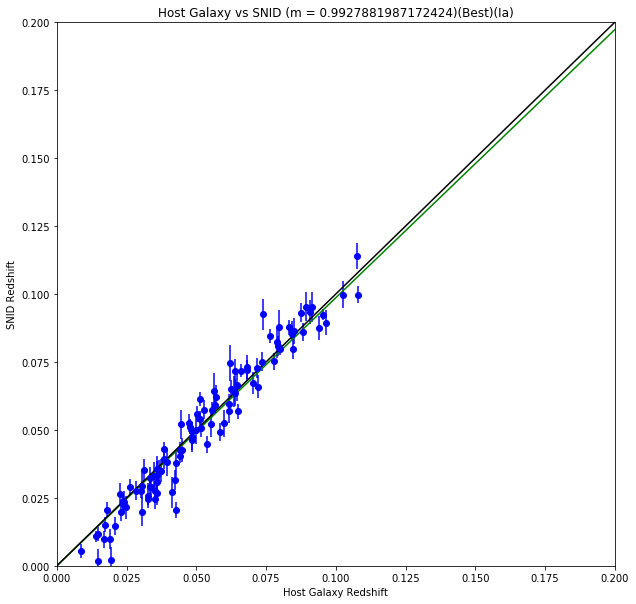

In [111]:
fig = plt.figure(figsize = (10,10))
plt.xlim(0,.2)
plt.ylim(0,.2)
plt.errorbar(rlap10_redshift_best_Ia_good["z_host"], rlap10_redshift_best_Ia_good["z_snid"], rlap10_redshift_best_Ia_good["z_snid_err"], fmt = "o", color = "blue")
plt.title("Host Galaxy vs SNID (m = " + str(regr_best_Ia_JoinedResults.coef_[0][0]) + ")(Best)(Ia)")
plt.xlabel("Host Galaxy Redshift")
plt.ylabel("SNID Redshift")
plt.plot(ranges_average_same_good, ypredict_average_same_good, color = "green")
plt.plot(ranges_average_same_good, ranges_average_same_good, color = "black")

In [112]:
print(stats.median_absolute_deviation(rlap10_redshift_best_Ia_good["z_snid"] - rlap10_redshift_best_Ia_good["z_host"]))
print(stats.median_absolute_deviation((rlap10_redshift_best_Ia_good["z_snid"] - rlap10_redshift_best_Ia_good["z_host"]) / rlap10_redshift_best_Ia_good["z_host"]))
print(stats.median_absolute_deviation(((rlap10_redshift_best_Ia_good["z_snid"] - rlap10_redshift_best_Ia_good["z_host"]) / rlap10_redshift_best_Ia_good["z_snid_err"])))
print(np.std(rlap10_redshift_best_Ia_good["z_snid"] - rlap10_redshift_best_Ia_good["z_host"]))
print(np.std((rlap10_redshift_best_Ia_good["z_snid"] - rlap10_redshift_best_Ia_good["z_host"]) / rlap10_redshift_best_Ia_good["z_host"]))
print(np.std(((rlap10_redshift_best_Ia_good["z_snid"] - rlap10_redshift_best_Ia_good["z_host"]) / rlap10_redshift_best_Ia_good["z_snid_err"])))

0.005562715200000005
0.12468498436161055
1.5918730035266495
0.007093160675725773
0.21450824479496114
1.78183662531047
